In [2]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp
import multiprocessing as mp

In [ ]:
### TESTING THE DIFFERENT POWER SOURCES FOR THE HV SUPPLY, AS WELL AS ISOLATING THE CHAMBER FROM THE SCROLL PUMP AND ION GAUGE ###

#The analog test was using the analog HV supply, while the chamber was connected to the turbo pump with no isolation.
#The analog break test was also using the analog HV supply but with the vacuum chamber separated from the pump and ion guage with ceramic breaks.
#The digital test was using the digital HV supply that is used for SiPM tests, also while the chamber was isolated from the pump and guage with ceramic breaks.

In [3]:
roomtest_an = "../roomtests/DataR_CH1@DT5730_1463_150um_roomtest_analoghv.lh5"
roomtest_an_brk = "../roomtests/DataR_CH1@DT5730_1463_150um_roomtest_analoghv_break.lh5"
roomtest_dig = "../roomtests/DataR_CH1@DT5730_1463_150um_roomtest_dighv.lh5"
dsp_roomtest_an  = "../roomtests/DataR_CH1@DT5730_1463_150um_roomtest_analoghv_dsp.lh5"
dsp_roomtest_an_brk  = "../roomtests/DataR_CH1@DT5730_1463_150um_roomtest_analoghv_break_dsp.lh5"
dsp_roomtest_dig = "../roomtests/DataR_CH1@DT5730_1463_150um_roomtest_dighv_dsp.lh5"

This DSP configuration file will produce the `trapEftp` parameter. You can scroll to the bottom and work your way back to see all the processors we need to generate it.

There are a couple of parameters that can be optimized in order to get the best energy resolution:
<ul>
    <li> pz_tau </li>
    <li> etrap.rise  </li>
    <li> etrap.flat </li>
    <li> ftp </li>
</ul>

We know what `pz_tau` should be from the decay constant measurement, so we don't need to optimize it.

`etrap.flat` just needs to be decently longer than the rise time of the waveform, so don't worry about it too much

`ftp` is set relative to the parameter of the energy trapezoid, to make sure that we're picking from the flat top

That leaves `etrap.flat` to be optimized. You can do this manually, by just typing in different numbers into the cell below. You can also write some code to loop through some numbers and run the DSP. Your optimization condition is when your peak has the best resolution - either minimize the width or maximize the height. 


In [4]:
dsp_config = {
    "outputs": ["bl", "trapEftp", "wf_pz", "wf_blsub", "wf_etrap"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [5]:
## what data we are using ##
input_file = roomtest_an_brk
output_file = dsp_roomtest_an_brk

In [6]:
## DSP for data taken with 2 ns sample rate

rise = 3.8
flat = 0.1


dsp_db = {
    "CompassEvent": {
        "pz_tau": "0.5*ms",
        "etrap": {
            "rise": f"{rise}*us",
            "flat": f"{flat}*us"
        },
        "ftp": 1000 + (rise + 0.5*flat)/(0.002)    
    }
}

build_dsp(
    f_raw=input_file, 
    f_dsp=output_file,
    lh5_tables = "CompassEvent",
    dsp_config = dsp_config,
    database = dsp_db,
    write_mode = 'r'
)

Processing table CompassEvent:  48%|####7     | 3200/6681 [00:07<00:08, 411.31 rows/s]

In [7]:
filechoice = output_file
f = h5py.File(filechoice)
trapEftp = f['CompassEvent']['trapEftp']
trap_data = trapEftp

182.0 286.0357 1.5748754 3.7088314604759214


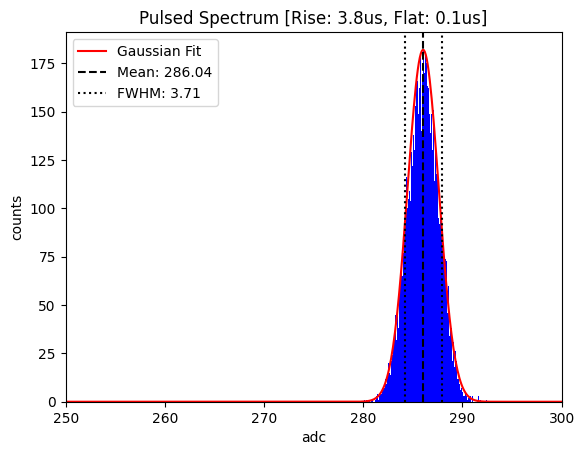

In [8]:
gd_e = 3271.2 #keV
gd_counts_mean = 566 #adc
adc2e = gd_e/gd_counts_mean
linamp_mean = 1214.27
thick_detector_pulse_mean = 548.7219
linamp_factor = thick_detector_pulse_mean/linamp_mean

adc = True
if adc:
    e = False
else: 
    e = True


def select_n_cut():
    if e:   
        noise_cut = trap_data[:] * adc2e
    else:
        noise_cut = trap_data[:]
        noise_cut = noise_cut[noise_cut > 270]
    return noise_cut


def gaussian(x, A, mean, std):
    return A * np.exp(-1 * ((x-mean)**2)/(2* std**2))



data = select_n_cut()

if adc:
    bins = np.linspace(0, 500, 5001)
else:
    bins = np.linspace(0, 1000, 1001) * adc2e



counts, _, _ = plt.hist(data, bins=bins, color='blue')

a = np.max(counts)
mean = np.mean(data)
std = np.std(data)

fwhm = 2.355*std

gaussian_fit = gaussian(bins, a, mean, std)

plt.plot(bins, gaussian_fit, color = 'red', label='Gaussian Fit')
plt.axvline(mean, color='black', linestyle='--', label='Mean: ' + str(round(mean, 2)))
plt.axvline(mean + fwhm/2, color='black', linestyle=':', label='FWHM: ' + str(round(fwhm, 2)))
plt.axvline(mean - fwhm/2, color='black', linestyle=':')
plt.ylabel("counts")
plt.xlabel("adc")
plt.title(f'Pulsed Spectrum [Rise: {rise}us, Flat: {flat}us]')
#plt.xlim(350,650)
plt.xlim(250,300)
#plt.xlim(525, 575)
#plt.xlim(460,760)
plt.legend()

print(a, mean, std, fwhm)


I included `wf_blsub`, `wf_pz`, and `wf_etrap` in the output - normally we wouldn't save these since they take up a lot of space. You only have one file though, and it can be instructive to see what the actual output of the pole zero or trapezoidal filter looks like, and how it varies when you change the parameters. Below is some code to help you visualize it.

In [9]:
wf_blsub = f['CompassEvent']['wf_blsub']['values']
wf_pz = f['CompassEvent']['wf_pz']['values']
wf_etrap = f['CompassEvent']['wf_etrap']['values']

super_wf_blsub = np.average(wf_blsub/np.max(wf_blsub, axis=1)[:,None], axis=0)
super_wf_pz = np.average(wf_pz/np.max(wf_pz, axis=1)[:,None], axis=0)
super_wf_etrap = np.average(wf_etrap/np.max(wf_etrap, axis=1)[:,None], axis=0)

(900.0, 1200.0)

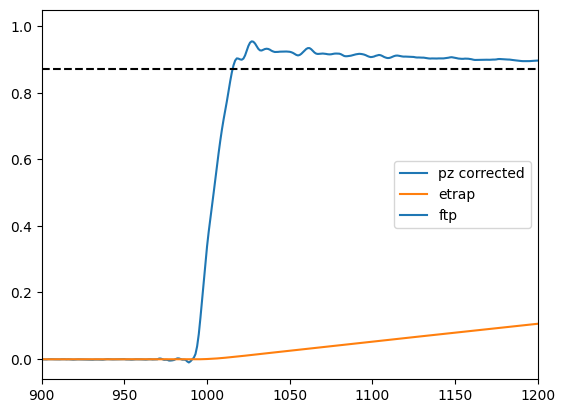

In [10]:
#plt.figure(figsize=(12,10))
#plt.plot(super_wf_blsub, label="original");
plt.plot(super_wf_pz, label="pz corrected");
plt.plot(super_wf_etrap, label="etrap");
plt.axvline(dsp_db["CompassEvent"]["ftp"], label="ftp");
plt.axhline(0.87, color='black', linestyle='--')
plt.legend()
plt.xlim(900, 1200)

In [11]:
dsp_config2 = {
    "outputs": ["bl", "trapEftp"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [12]:
## What Data are we processing ##
opt_filechoice = roomtest_an_brk
opt_file_out_start = "roomtest_outs/roomtest_an_brk_dsp_rise_"
            # FORMAT: roomtest_outs/roomtest_an_dsp_rise_
            #         roomtest_outs/roomtest_an_brk_dsp_rise_
            #         roomtest_outs/roomtest_dig_dsp_rise_
opt_file_out_start_wfs = "roomtest_outs/roomtest_an_brk_wfs_rise_"
            # FORMAT:     roomtest_outs/roomtest_an_wfs_rise_
            #             roomtest_outs/roomtest_an_brk_wfs_rise_
            #             roomtest_outs/roomtest_dig_wfs_rise_

title = "Analog HV with Break Pulse Test"

In [13]:
def process_data(rise,flat):
    dsp_db = {
        "CompassEvent": {
            "pz_tau": "0.5*ms",
            "etrap": {
                "rise": f"{rise}*us",
                "flat": f"{flat}*us"
            },
            "ftp": 1000 + (rise + 0.5*flat)/(0.002)
        }
    }
    #potentially put a path here for f_dsp if you want it all in a directory
    build_dsp(
        f_raw=opt_filechoice, 
        f_dsp= opt_file_out_start + f"{rise:.2f}_flat_{flat:.2f}.lh5",    #fix
        lh5_tables = f"CompassEvent",
        dsp_config = dsp_config2,
        database = dsp_db,
        write_mode = 'r'
    )

def make_iterable(rises, flats):
    iterable = []
    for rise in rises:
        for flat in flats:
            iterable.append((rise,flat))
    return iterable

flats = np.linspace(0.1, 3, 30) # Change this
rises = np.linspace(0.1, 5, 50)
cores = 6


# commented out so dont accidentally run
'''
iterable = make_iterable(rises, flats)
#print(iterable)
chunk = int(round(len(rises)*len(flats)/cores))

with mp.Pool(processes=cores) as p:
    p.starmap(process_data, iterable, chunksize=chunk)

'''

'\niterable = make_iterable(rises, flats)\n#print(iterable)\nchunk = int(round(len(rises)*len(flats)/cores))\n\nwith mp.Pool(processes=cores) as p:\n    p.starmap(process_data, iterable, chunksize=chunk)\n\n'

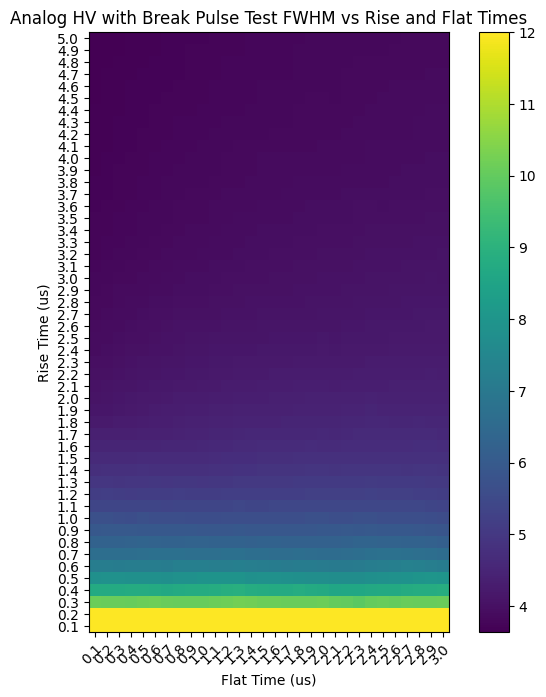

In [14]:
def plot_heat_map(fwhm_array, rises_choice, flats_choice, type = "run#"):
    figgy, axs = plt.subplots(figsize=(10, 10))
    im = axs.imshow(fwhm_array, vmax=12., origin='lower')
    axs.set_xticks(np.arange(len(flats_choice)), labels=np.round(flats_choice, decimals=1))
    axs.set_yticks(np.arange(len(rises_choice)), labels=np.round(rises_choice, decimals=1))
    plt.setp(axs.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    axs.set_title(type+" FWHM vs Rise and Flat Times")
    axs.set_xlabel("Flat Time (us)")
    axs.set_ylabel("Rise Time (us)")
    plt.colorbar(im)
    figgy.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.show()

all_flats = np.linspace(0.1, 3, 30) # Change this
all_rises = np.linspace(0.1, 5, 50)

fwhm_array = np.zeros((len(all_rises), len(all_flats)))
for i, rise in enumerate(all_rises):
    for j, flat in enumerate(all_flats):
        filechoice = opt_file_out_start + f"{rise:.2f}_flat_{flat:.2f}.lh5"
        f = h5py.File(filechoice)
        trapEftp = f['CompassEvent']['trapEftp']
        trap_data = trapEftp
        data = select_n_cut()
        #x = np.linspace(0, 500, 5001)
        std = np.std(data)
        fwhm = 2.355*std
        fwhm_array[i][j] = fwhm


plot_heat_map(fwhm_array, all_rises, all_flats, type = title)

In [15]:
min_index = np.argmin(fwhm_array)
min_fwhm = np.min(fwhm_array)
row, col = np.unravel_index(min_index, fwhm_array.shape)  # Convert the flattened index to row and column indices
best_rise = all_rises[row]
best_flat = all_flats[col]
print(row,col)
print(f'Rise: {best_rise}us, Flat: {best_flat}us')
print(f'Minimum FWHM: {min_fwhm}')


dsp_db = {
    "CompassEvent": {
        "pz_tau": "0.5*ms",
        "etrap": {
            "rise": f"{best_rise}*us",
            "flat": f"{best_flat}*us"
        },
        "ftp": 1000 + (best_rise + 0.5*best_flat)/(0.002)    #somethings wrong here
    }
}

build_dsp(
        f_raw=opt_filechoice, 
        f_dsp=opt_file_out_start_wfs + f"{best_rise:.2f}_flat_{best_flat:.2f}.lh5",    #fix
        lh5_tables = f"CompassEvent",
        dsp_config = dsp_config,
        database = dsp_db,
        write_mode = 'r'
    )

49 0
Rise: 5.0us, Flat: 0.1us
Minimum FWHM: 3.6357416349649427


Processing table CompassEvent:  48%|####7     | 3200/6681 [00:07<00:08, 420.77 rows/s]

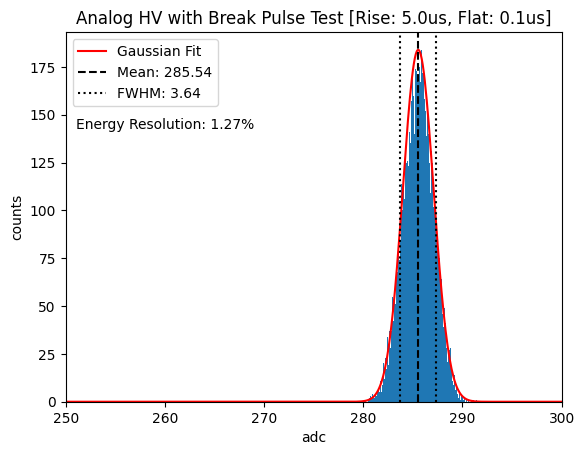

In [19]:
f = h5py.File(opt_file_out_start_wfs + f"{best_rise:.2f}_flat_{best_flat:.2f}.lh5")
trapEftp = f['CompassEvent']['trapEftp']
trap_data = trapEftp

best_data = select_n_cut()
#best_data = best_data[best_data > 400]
best_counts, _, _ = plt.hist(best_data, bins=bins)  #need
b_a = np.max(best_counts)
b_mean = np.mean(best_data)
b_std = np.std(best_data)
b_fwhm = 2.355*b_std
e_res = b_fwhm/b_mean

gaussian_fit2 = gaussian(bins, b_a, b_mean, b_std)
plt.plot(bins, gaussian_fit2, color = 'red', label='Gaussian Fit')
plt.axvline(b_mean, color='black', linestyle='--', label='Mean: ' + str(round(b_mean, 2)))
plt.axvline(b_mean + b_fwhm/2, color='black', linestyle=':', label='FWHM: ' + str(round(b_fwhm, 2)))
plt.axvline(b_mean - b_fwhm/2, color='black', linestyle=':')
plt.text(0.20, 0.75, f'Energy Resolution: {round(e_res*100, 2)}%', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.ylabel("counts")
plt.xlabel("adc")
plt.title(title + f' [Rise: {best_rise}us, Flat: {best_flat}us]')
plt.xlim(250,300)
plt.legend()
plt.show()


(950.0, 1050.0)

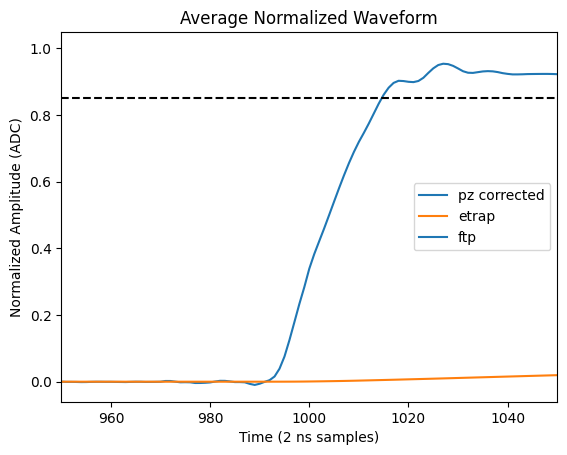

In [20]:
wf_blsub = f['CompassEvent']['wf_blsub']['values']
wf_pz = f['CompassEvent']['wf_pz']['values']
wf_etrap = f['CompassEvent']['wf_etrap']['values']

super_wf_blsub = np.average(wf_blsub/np.max(wf_blsub, axis=1)[:,None], axis=0)
super_wf_pz = np.average(wf_pz/np.max(wf_pz, axis=1)[:,None], axis=0)
super_wf_etrap = np.average(wf_etrap/np.max(wf_etrap, axis=1)[:,None], axis=0)

#plt.figure(figsize=(12,10))
#plt.plot(super_wf_blsub, label="original");
plt.plot(super_wf_pz, label="pz corrected");
plt.plot(super_wf_etrap, label="etrap");
plt.axvline(dsp_db["CompassEvent"]["ftp"], label="ftp");
plt.axhline(0.85, color='black', linestyle='--')
plt.xlabel("Time (2 ns samples)")
plt.ylabel("Normalized Amplitude (ADC)")
plt.title("Average Normalized Waveform")
plt.legend()
plt.xlim(950, 1050)